In [2]:
import numpy as np
import pandas as pd
import re

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('gurgaon_properties_cleaned_v1.csv')

In [5]:
df.duplicated().sum()

np.int64(122)

In [6]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,signature global solera,sector 107,0.5,7751.0,645.0,Carpet area: 645 (59.92 sq.m.),3,2,2,others,6.0,South-East,1 to 5 Year Old,"['Gurgaon Dreamz Mall', 'Dwarka Expressway', ""Colonel's Central Academy"", 'The NorthCap University', 'Chirag Hospital', 'Indira Gandhi International Airport', 'Trident Hotel Gurgaon', 'Fun N Food Village', 'DLF Golf and Country Club', 'F9 Go Karting Gurgaon', 'SkyJumper Trampoline Park Gurgaon']",NaN,"['Intercom Facility', 'Lift(s)', 'Park']"


Plan of action: work on columns "areaWithType", "additionalRoom","agePossession","features", "furnishDetails"

**1. areaWithType**

In [7]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
328,8.00,347.0,Built Up area: 347 (32.24 sq.m.)Carpet area: 215 sq.ft. (19.97 sq.m.)
3057,1.77,2408.0,Super Built up area 2408(223.71 sq.m.)Built Up area: 1450 sq.ft. (134.71 sq.m.)Carpet area: 1300 sq.ft. (120.77 sq.m.)
1504,11.50,3240.0,Built Up area: 3240 (301.01 sq.m.)
3368,0.65,1300.0,Super Built up area 1300(120.77 sq.m.)
1899,3.75,3400.0,Built Up area: 3400 (315.87 sq.m.)Carpet area: 1836 sq.ft. (170.57 sq.m.)


different types of areas, discrepancy in units for the same property. Need to resolve this. Creating three seperate columns 'Super Builtup area', 'Builtup Area' and 'Carpet Area'


In [8]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [9]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [10]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [11]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [12]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
516,1.25,flat,2651.0,Carpet area: 2651 (246.29 sq.m.),NaN,NaN,2651.0
1929,1.12,flat,1790.0,Super Built up area 1790(166.3 sq.m.)Carpet area: 1400 sq.ft. (130.06 sq.m.),1790.0,NaN,1400.0
3778,1.30,flat,1444.0,Carpet area: 1444 (134.15 sq.m.),NaN,NaN,1444.0
1953,3.00,flat,2600.0,Super Built up area 2802(260.31 sq.m.)Built Up area: 2600 sq.ft. (241.55 sq.m.)Carpet area: 2200 sq.ft. (204.39 sq.m.),2802.0,2600.0,2200.0
1272,3.87,house,7500.0,Plot area 1623(150.78 sq.m.)Built Up area: 7500 sq.ft. (696.77 sq.m.),NaN,7500.0,NaN


In [13]:
df.duplicated().sum()

np.int64(122)

In [14]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [15]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,7.00,house,5400.0,Plot area 600(501.68 sq.m.),NaN,NaN,NaN
10,10.00,house,3600.0,Plot area 400(334.45 sq.m.),NaN,NaN,NaN
11,6.50,house,3150.0,Plot area 350(292.64 sq.m.),NaN,NaN,NaN
13,5.70,house,5400.0,Plot area 600(501.68 sq.m.),NaN,NaN,NaN
15,4.35,house,5481.0,Plot area 5480(509.11 sq.m.),NaN,NaN,NaN


In [16]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [17]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [18]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,7.00,house,5400.0,Plot area 600(501.68 sq.m.),NaN,NaN,NaN
10,10.00,house,3600.0,Plot area 400(334.45 sq.m.),NaN,NaN,NaN
11,6.50,house,3150.0,Plot area 350(292.64 sq.m.),NaN,NaN,NaN
13,5.70,house,5400.0,Plot area 600(501.68 sq.m.),NaN,NaN,NaN
15,4.35,house,5481.0,Plot area 5480(509.11 sq.m.),NaN,NaN,NaN


In [19]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [20]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [21]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [22]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,7.00,house,5400.0,Plot area 600(501.68 sq.m.),NaN,600.00,NaN
10,10.00,house,3600.0,Plot area 400(334.45 sq.m.),NaN,400.00,NaN
11,6.50,house,3150.0,Plot area 350(292.64 sq.m.),NaN,350.00,NaN
13,5.70,house,5400.0,Plot area 600(501.68 sq.m.),NaN,600.00,NaN
15,4.35,house,5481.0,Plot area 5480(509.11 sq.m.),NaN,5480.00,NaN
24,0.75,house,1170.0,Plot area 130(108.7 sq.m.),NaN,130.00,NaN
28,1.60,house,508.0,Plot area 60(50.17 sq.m.),NaN,60.00,NaN
35,0.61,house,61.0,Plot area 61(5.67 sq.m.),NaN,61.00,NaN
41,4.45,house,2880.0,Plot area 320(267.56 sq.m.),NaN,320.00,NaN
63,3.20,house,2250.0,Plot area 250(209.03 sq.m.),NaN,250.00,NaN


In [23]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [24]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [25]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
9,7.00,house,5400.0,Plot area 600(501.68 sq.m.),NaN,5400.00,NaN
10,10.00,house,3600.0,Plot area 400(334.45 sq.m.),NaN,3600.00,NaN
11,6.50,house,3150.0,Plot area 350(292.64 sq.m.),NaN,3150.00,NaN
13,5.70,house,5400.0,Plot area 600(501.68 sq.m.),NaN,5400.00,NaN
15,4.35,house,5481.0,Plot area 5480(509.11 sq.m.),NaN,5480.00,NaN
24,0.75,house,1170.0,Plot area 130(108.7 sq.m.),NaN,1170.00,NaN
28,1.60,house,508.0,Plot area 60(50.17 sq.m.),NaN,60.00,NaN
35,0.61,house,61.0,Plot area 61(5.67 sq.m.),NaN,61.00,NaN
41,4.45,house,2880.0,Plot area 320(267.56 sq.m.),NaN,2880.00,NaN
63,3.20,house,2250.0,Plot area 250(209.03 sq.m.),NaN,2250.00,NaN


In [26]:
df.update(all_nan_df)

In [27]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [28]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,signature global solera,sector 107,0.50,7751.0,645.0,Carpet area: 645 (59.92 sq.m.),3,2,2,others,6.0,South-East,1 to 5 Year Old,"['Gurgaon Dreamz Mall', 'Dwarka Expressway', ""Colonel's Central Academy"", 'The NorthCap University', 'Chirag Hospital', 'Indira Gandhi International Airport', 'Trident Hotel Gurgaon', 'Fun N Food Village', 'DLF Golf and Country Club', 'F9 Go Karting Gurgaon', 'SkyJumper Trampoline Park Gurgaon']",NaN,"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,645.0
1,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,0 to 1 Year Old,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul Preschool', 'Yaduvanshi Shiksha Niketan', 'Bharat Ram Global School', 'RPS International School', 'ICICI ATM', 'Silver Streak Hospital', 'Arc Multi Speciality', 'Sanjeevani Hospital', 'HDFC Bank', 'Sai Sports Club cricket ground', 'Nawada Cricket Accadmy', 'HP PETROL PUMP Unnamed Rd', 'INOX Cinema']","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Shopping Centre']",NaN,NaN,690.0
2,flat,vatika gurgaon,sector 83,1.19,7437.0,1600.0,Carpet area: 1600 (148.64 sq.m.),3,3,2,servant room,10.0,South,1 to 5 Year Old,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']","['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '3 Geyser', '6 Light', '1 Curtains', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']",NaN,NaN,1600.0
3,flat,emaar mgf the palm drive,sector 66,1.51,15130.0,998.0,Super Built up area 1200(111.48 sq.m.)Built Up area: 1188 sq.ft. (110.37 sq.m.)Carpet area: 998 sq.ft. (92.72 sq.m.),2,2,2,pooja room,5.0,North,1 to 5 Year Old,"['Sector 55-56 Rapid Metro Station', 'HUB 66', 'NH 248A', 'Hasanpur', 'Ashoka International School', 'Gurugram University', 'Park Hospital', 'Indira Gandhi International Airport', 'Sealdah', 'Vatika Business Centre', 'The Oberoi Gurgaon', 'De Adventure Park', 'DLF Golf and Country Club', 'Tau DeviLal Sports Complex']","['3 Wardrobe', '5 Fan', '1 Exhaust Fan', '4 Geyser', '6 Light', '5 AC', '1 Curtains', 'No Bed', 'No Chimney', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'Piped-gas', 'Swimming Pool', 'Park', 'Security Personnel', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Club house / Community Center', 'Water softening plant']",1200.0,1188.0,998.0
4,flat,emaar digihomes,sector 62,2.15,14257.0,1508.0,Carpet area: 1508 (140.1 sq.m.),2,2,3,not available,31.0,NaN,Under Construction,"['Sector 55-56 Metro Station', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy,Sector 48', 'Heritage School', 'Lotus Valley Intl School, Gurgaon', 'Gurugram University', 'Sushant University', 'Park Hospital', 'Indira Gandhi Intl Airport', 'Imperia Mindspace', 'AIPL Business Tower']",NaN,"['Security /

**2. additionalRoom**

Converting the additionalRooms column to seperate columns with 0 and 1, 0 if absent, 1 if present

In [29]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
store room                                         99
study room,servant room                            99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
pooja room,st

In [30]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [31]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
3122,servant room,0,1,0,0,0
2934,not available,0,0,0,0,0
2753,"pooja room,study room,servant room,store room",1,1,1,1,0
2596,servant room,0,1,0,0,0
3239,servant room,0,1,0,0,0


In [32]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,signature global solera,sector 107,0.50,7751.0,645.0,Carpet area: 645 (59.92 sq.m.),3,2,2,others,6.0,South-East,1 to 5 Year Old,"['Gurgaon Dreamz Mall', 'Dwarka Expressway', ""Colonel's Central Academy"", 'The NorthCap University', 'Chirag Hospital', 'Indira Gandhi International Airport', 'Trident Hotel Gurgaon', 'Fun N Food Village', 'DLF Golf and Country Club', 'F9 Go Karting Gurgaon', 'SkyJumper Trampoline Park Gurgaon']",NaN,"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,645.0,0,0,0,0,1
1,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,0 to 1 Year Old,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul Preschool', 'Yaduvanshi Shiksha Niketan', 'Bharat Ram Global School', 'RPS International School', 'ICICI ATM', 'Silver Streak Hospital', 'Arc Multi Speciality', 'Sanjeevani Hospital', 'HDFC Bank', 'Sai Sports Club cricket ground', 'Nawada Cricket Accadmy', 'HP PETROL PUMP Unnamed Rd', 'INOX Cinema']","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Shopping Centre']",NaN,NaN,690.0,0,0,0,0,0
2,flat,vatika gurgaon,sector 83,1.19,7437.0,1600.0,Carpet area: 1600 (148.64 sq.m.),3,3,2,servant room,10.0,South,1 to 5 Year Old,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']","['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '3 Geyser', '6 Light', '1 Curtains', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']",NaN,NaN,1600.0,0,1,0,0,0
3,flat,emaar mgf the palm drive,sector 66,1.51,15130.0,998.0,Super Built up area 1200(111.48 sq.m.)Built Up area: 1188 sq.ft. (110.37 sq.m.)Carpet area: 998 sq.ft. (92.72 sq.m.),2,2,2,pooja room,5.0,North,1 to 5 Year Old,"['Sector 55-56 Rapid Metro Station', 'HUB 66', 'NH 248A', 'Hasanpur', 'Ashoka International School', 'Gurugram University', 'Park Hospital', 'Indira Gandhi International Airport', 'Sealdah', 'Vatika Business Centre', 'The Oberoi Gurgaon', 'De Adventure Park', 'DLF Golf and Country Club', 'Tau DeviLal Sports Complex']","['3 Wardrobe', '5 Fan', '1 Exhaust Fan', '4 Geyser', '6 Light', '5 AC', '1 Curtains', 'No Bed', 'No Chimney', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'Piped-gas', 'Swimming Pool', 'Park', 'Security Personnel', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Club house / Community Center', 'Water softening plant']",1200.0,1188.0,998.0,0,0,0,1,0
4,flat,emaar digihomes,sector 62,2.15,14257.0,1508.0,Carpet area: 1508 (140.1 sq.m.),2,2,3,not available,31.0,NaN,Under Construction,"['Sector 55-56 Metro Station', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy,Sector 48', 'Heritage School', 'Lotus Valley Intl School, Gurgaon', 'Gurugram University', 'Sushant University', 'Park Hospital',

**3. agePossession**

In [33]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec-23                  22
By 2023                 19
By 2024                 17
Dec-24                  16
Mar-24                  14
Jan-24                   8
Oct-24                   8
Dec-25                   7
Aug-23                   7
Jun-24                   7
Nov-23                   5
By 2025                  4
Jul-24                   4
Oct-23                   4
Aug-24                   4
Sep-23                   4
Jan-25                   3
Nov-24                   3
May-24                   3
Feb-24                   3
Jul-25                   2
By 2027                  2
Jun-27                   2
Apr-26                   2
Dec-26                   2
Jul-27                   2
Mar-25                   2
Oct-25                   2
Jan-26        

In [34]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value:
        return "Under Construction"
    # Check for date-like entries
    try:
        # For entries like 'May 2024', 'July-25', etc.
        match = re.search(r'([A-Za-z]+)[\s\-]?(\d{4}|\d{2})', value)
        if match:
            month_str = match.group(1)
            year_str = match.group(2)
            # Convert year to 4 digits if needed
            year = int(year_str)
            if year < 100:
                year += 2000
            # Convert month to number
            month_map = {
                'January': 1, 'Jan': 1,
                'February': 2, 'Feb': 2,
                'March': 3, 'Mar': 3,
                'April': 4, 'Apr': 4,
                'May': 5,
                'June': 6, 'Jun': 6,
                'July': 7, 'Jul': 7,
                'August': 8, 'Aug': 8,
                'September': 9, 'Sep': 9,
                'October': 10, 'Oct': 10,
                'November': 11, 'Nov': 11,
                'December': 12, 'Dec': 12
            }
            month = month_map.get(month_str, 1)
            # Compare with July 2025
            if (year > 2025) or (year == 2025 and month > 7):
                return "Under Construction"
            elif (year == 2023 and month >= 1) or (year == 2024) or (year == 2025 and month <= 7):
                return "New Property"
        return "Undefined"
    except:
        return "Undefined"

In [35]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,signature global solera,sector 107,0.50,7751.0,645.0,Carpet area: 645 (59.92 sq.m.),3,2,2,others,6.0,South-East,1 to 5 Year Old,"['Gurgaon Dreamz Mall', 'Dwarka Expressway', ""Colonel's Central Academy"", 'The NorthCap University', 'Chirag Hospital', 'Indira Gandhi International Airport', 'Trident Hotel Gurgaon', 'Fun N Food Village', 'DLF Golf and Country Club', 'F9 Go Karting Gurgaon', 'SkyJumper Trampoline Park Gurgaon']",NaN,"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,645.0,0,0,0,0,1
1,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,0 to 1 Year Old,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul Preschool', 'Yaduvanshi Shiksha Niketan', 'Bharat Ram Global School', 'RPS International School', 'ICICI ATM', 'Silver Streak Hospital', 'Arc Multi Speciality', 'Sanjeevani Hospital', 'HDFC Bank', 'Sai Sports Club cricket ground', 'Nawada Cricket Accadmy', 'HP PETROL PUMP Unnamed Rd', 'INOX Cinema']","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Shopping Centre']",NaN,NaN,690.0,0,0,0,0,0
2,flat,vatika gurgaon,sector 83,1.19,7437.0,1600.0,Carpet area: 1600 (148.64 sq.m.),3,3,2,servant room,10.0,South,1 to 5 Year Old,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']","['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '3 Geyser', '6 Light', '1 Curtains', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']",NaN,NaN,1600.0,0,1,0,0,0
3,flat,emaar mgf the palm drive,sector 66,1.51,15130.0,998.0,Super Built up area 1200(111.48 sq.m.)Built Up area: 1188 sq.ft. (110.37 sq.m.)Carpet area: 998 sq.ft. (92.72 sq.m.),2,2,2,pooja room,5.0,North,1 to 5 Year Old,"['Sector 55-56 Rapid Metro Station', 'HUB 66', 'NH 248A', 'Hasanpur', 'Ashoka International School', 'Gurugram University', 'Park Hospital', 'Indira Gandhi International Airport', 'Sealdah', 'Vatika Business Centre', 'The Oberoi Gurgaon', 'De Adventure Park', 'DLF Golf and Country Club', 'Tau DeviLal Sports Complex']","['3 Wardrobe', '5 Fan', '1 Exhaust Fan', '4 Geyser', '6 Light', '5 AC', '1 Curtains', 'No Bed', 'No Chimney', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'Piped-gas', 'Swimming Pool', 'Park', 'Security Personnel', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Club house / Community Center', 'Water softening plant']",1200.0,1188.0,998.0,0,0,0,1,0
4,flat,emaar digihomes,sector 62,2.15,14257.0,1508.0,Carpet area: 1508 (140.1 sq.m.),2,2,3,not available,31.0,NaN,Under Construction,"['Sector 55-56 Metro Station', 'Omaxe Gurgaon Mall', 'Badshahpur Sohna Rd Hwy,Sector 48', 'Heritage School', 'Lotus Valley Intl School, Gurgaon', 'Gurugram University', 'Sushant University', 'Park Hospital',

In [36]:
df['agePossession']= df['agePossession'].apply(categorize_age_possession)

In [37]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           787
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     122
Name: count, dtype: int64

**4. furnishDetails**

Extracted all the furnishing details into columns and assigned values for how many of those items are installed in the flats

In [38]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
2144,NaN,"['Feng Shui / Vaastu Compliant', 'Lift(s)', 'Swimming Pool', 'Maintenance Staff', 'Park', 'Security Personnel', 'Club house / Community Center', 'Rain Water Harvesting', 'Water softening plant']"
1834,"['3 Wardrobe', '1 Modular Kitchen', '1 Chimney', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
2869,NaN,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Water Storage', 'Park', 'Visitor Parking']"
2849,"['7 Wardrobe', '7 Fan', '1 Exhaust Fan', '19 Light', '1 Modular Kitchen', '6 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center', 'Water softening plant']"
420,NaN,"['Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'Piped-gas', 'Swimming Pool', 'Park', 'Internet/wi-fi connectivity', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant']"


In [39]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
C:\Users\abhin\AppData\Local\Temp\ipykernel_7112\2445438592.py:13: SyntaxWarning: invalid escape sequence '\d'
  pattern = re.compile(f"(\d+) {furnishing}")


In [40]:
furnishings_df.shape

(3803, 19)

In [41]:
furnishings_df.sample(5)

,furnishDetails,Sofa,Dining Table,Bed,Fan,Light,Wardrobe,Chimney,AC,Water Purifier,Geyser,Fridge,Exhaust Fan,Curtains,Stove,Microwave,Modular Kitchen,TV,Washing Machine
3025,"['3 Wardrobe', '7 Fan', '1 Exhaust Fan', '3 Geyser', '11 Light', '1 Chimney', '1 Modular Kitchen', '1 Curtains', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",0,0,0,7,11,3,1,0,0,3,0,1,1,0,0,1,0,0
481,"['1 Exhaust Fan', '1 Stove', '1 Light', '1 AC', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0
45,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2898,"['1 Fan', '1 Geyser', '1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
985,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

C:\Users\abhin\AppData\Local\Temp\ipykernel_7112\114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [43]:
furnishings_df.sample(5)

,Sofa,Dining Table,Bed,Fan,Light,Wardrobe,Chimney,AC,Water Purifier,Geyser,Fridge,Exhaust Fan,Curtains,Stove,Microwave,Modular Kitchen,TV,Washing Machine
1337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
823,0,0,0,5,2,4,0,0,0,4,0,0,0,0,0,0,0,0
704,0,0,0,6,6,0,0,4,0,2,0,0,0,0,0,0,0,0
3498,0,0,0,3,6,1,1,3,0,0,0,0,0,0,0,0,0,0
3121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Now, we can use Kmeans to identify the total number of clusters which can be formed using this data and classify them info furnished, semifurnished, non furnished etc based on the values.

In [44]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [45]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [46]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

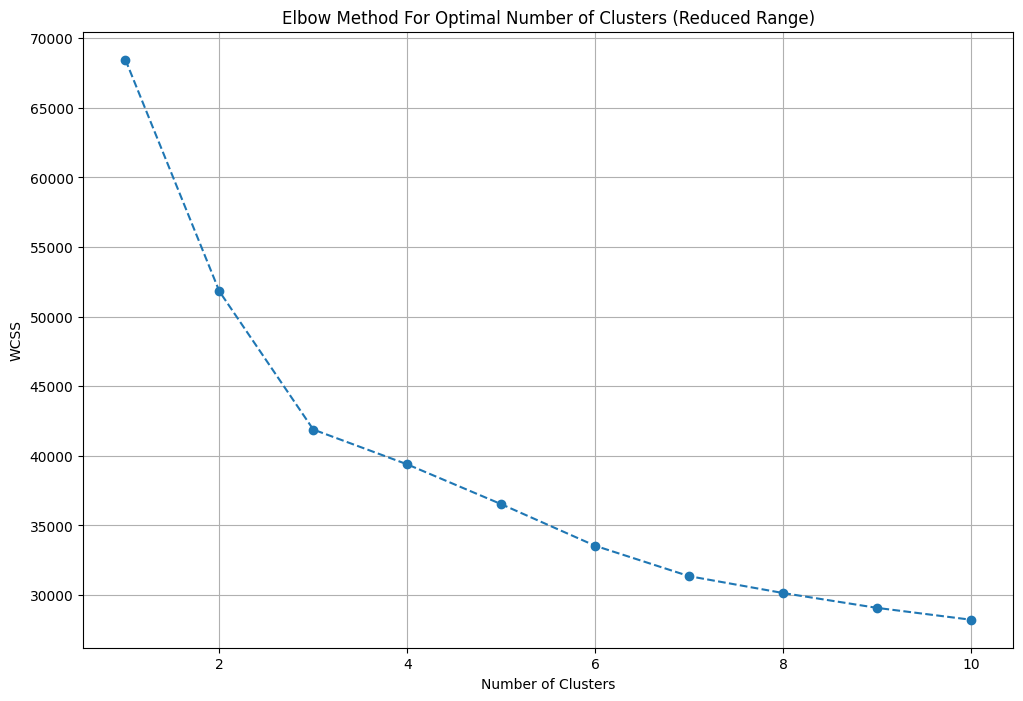

In [47]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Here the elbow curve gives the value of 3 which means our intution was correct and the furnishing details can largely be classified into "furnished", "semi-furnished" and "Non-furnished". Now, fitting the data into 3 clusters.

In [48]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [49]:
df = df.iloc[:,:-18]

In [50]:
df['furnishing_type'] = cluster_assignments

In [53]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
204,"['3 Wardrobe', '1 Water Purifier', '5 Fan', '1 Exhaust Fan', '4 Geyser', '14 Light', '5 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine']",1
2472,"['1 Water Purifier', '1 Fridge', '8 Fan', '1 Exhaust Fan', '1 Dining Table', '5 Geyser', '1 Stove', '21 Light', '1 Curtains', '1 Chimney', '1 Modular Kitchen', '5 Wardrobe', '2 Bed', '1 Sofa', '1 Washing Machine', '1 Microwave', 'No AC', 'No TV']",2
131,"['3 Wardrobe', '5 Fan', '3 Geyser', '1 Stove', '30 Light', '5 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine', 'No Water Purifier']",1
2721,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0
238,"['3 Wardrobe', '1 Water Purifier', '6 Fan', '1 Exhaust Fan', '4 Geyser', '1 Stove', '10 Light', '1 Chimney', '1 Modular Kitchen', '5 AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine']",1


In [54]:
df.sample(2)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type
2288,flat,sidhartha ncr greens,sector 95,0.56,5656.0,990.0,Super Built up area 990(91.97 sq.m.),2,2,3,not available,13.0,NaN,New Property,"['Yadav Clinic', 'Bangali Clinic', 'Dr. J. S. Sarkar Clinic', 'Vijay Petrol Pump']",[],"['Power Back-up', 'Lift(s)', 'Park', 'Piped-gas']",990.0,NaN,NaN,0,0,0,0,0,0
2527,house,rattan garden,sector 7,1.30,13499.0,963.0,Built Up area: 963 (89.47 sq.m.),5,3,2,not available,3.0,NaN,Old Property,"['Chintapurni Mandir', 'Aryan Hospital', 'D.R. Rajnis Gupta Clinic', 'Geeta Nursing Home Gurgaon', 'Ravi Clinic and Health Care Centre', 'Sparsh Hospital Gurgaon', 'Bhatnagar Maternity and Nursing Home', 'Gurgaon Eye Centre', 'Chiranjiv Hospital', 'Bindal Clinic', 'Pearl Dental Clinic', 'M.S Hospital', 'Taneja Hospital', 'Dr. Sarvejeet Singh', 'My Care Clinic', 'Centre For Sight Gurgaon New Railway Road', 'Triveni Hospital Gurgaon', 'Kidney Clinic', 'Dr. Ashok Jain', 'Swastik Maternity and Medical Centre', 'Dr. Agya Ram Sharma Clinic', 'Kharbanda Maternity and Nursing Home', 'Lalit Dental Care', 'Dr. Madan Clinic', 'Dentecare - Multispeciality Dental Clinic', 'Lall Eye Care Centre', 'Om Charitable Dental & Implant Centre', 'Lall Nursing and Maternity Home', 'M Goel Hospital', 'Dev Man Kathuria Clinic', 'Gupta Hospital Gurgaon', 'Jackson Hospital', 'Dental Health Centre', 'Satyam Hospital Gurgaon', 'Dr. Ajay S. Gupta Clinic', 'Sarvodya Hospital', 'GH Gurgaon', 'Jain Sant Phool Chand Ji Charitable Hospital', 'Nova Care Clinic', 'Verma E.N.T. Hospital', 'Rajiv Memorial Eye Infirmary Jacobpura', 'Dr. Sindhu Clinic', 'Sharma Hospital Gurgaon', 'State bank of india', 'Hdfc bank', 'Kotak bank', 'Indian bank', 'Pizza Hut', 'St. Michaels Sr. Sec. School', 'Dronacharya Government College']","['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",NaN,NaN,963.0,NaN,0,0,0,0,0,0


**5. features**

In [55]:
df[['society','features']].sample(5)

,society,features
323,ss the leaf,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
116,oriental valley chs,['Natural Light']
3189,antriksh heights,"['Power Back-up', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Swimming Pool', 'Maintenance Staff', 'Park', 'Visitor Parking', 'Internet/wi-fi connectivity', 'Fitness Centre / GYM', 'Club house / Community Center', 'Water softening plant']"
2121,pareena mi casa,NaN
3658,emaar digihomes,"['Swimming Pool', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [56]:
df['features'].isnull().sum()

np.int64(635)

In [57]:
# 635 features empty. Will extract some features of the society list from other web scraped file "apartments.csv"

In [58]:
import pandas as pd
app_df = pd.read_csv('appartments.csv')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"


Some of the features of the same societies are mentioned in this file, so we can extract those features to make out missing values lower

In [59]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [60]:
temp_df = df[df['features'].isnull()]

In [61]:
temp_df.shape

(635, 26)

In [62]:
# Left joining on the missing values

x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [63]:
df.loc[temp_df.index,'features'] = x.values

In [64]:
df['features'].isnull().sum()

np.int64(481)

If we try the same logic that we applied in "furnishDetails": That is, we first extract the facilites into columns and then get the total number of possible clusters. The cocde gives onlt two possible outcomes : "Furnished' and 'Non Furnished". This does not helps us a lot.

In [65]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [66]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [67]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1092,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0
134,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
1961,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0
3515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2947,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
features_binary_df.shape

(3803, 130)

In [69]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

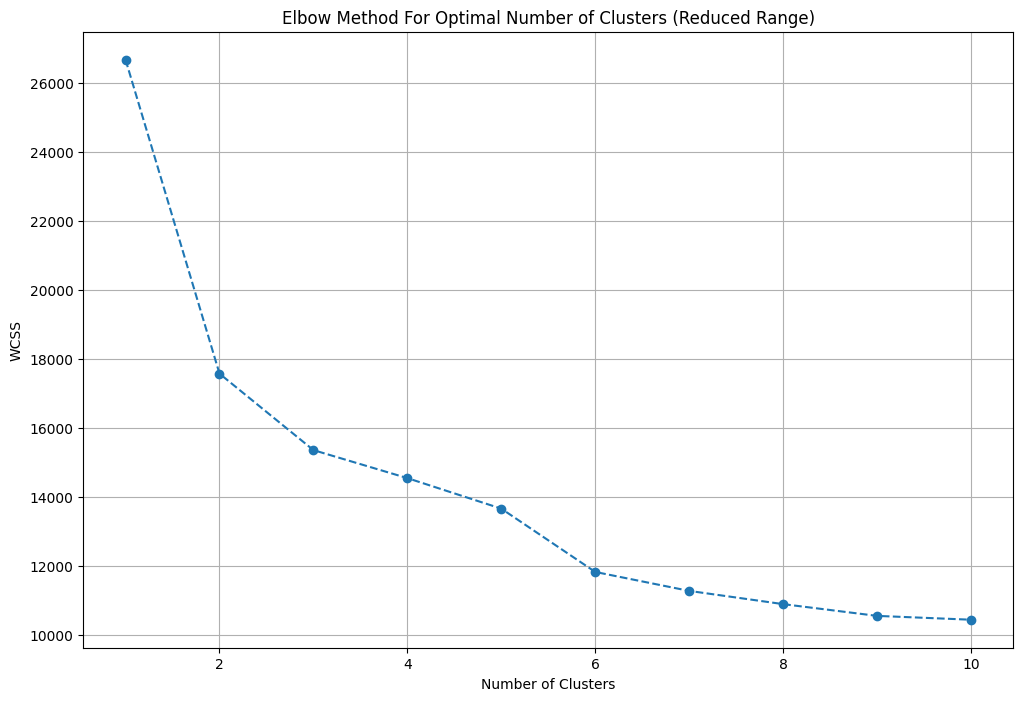

In [70]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Only two possible clusters!

Instead by using the help of AI and other online available sources, we assigned some weights to these features and calculated a "Total Luxury Score"

In [71]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [72]:
df['luxury_score'] = luxury_score

In [73]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,signature global solera,sector 107,0.50,7751.0,645.0,Carpet area: 645 (59.92 sq.m.),3,2,2,others,6.0,South-East,Relatively New,"['Gurgaon Dreamz Mall', 'Dwarka Expressway', ""Colonel's Central Academy"", 'The NorthCap University', 'Chirag Hospital', 'Indira Gandhi International Airport', 'Trident Hotel Gurgaon', 'Fun N Food Village', 'DLF Golf and Country Club', 'F9 Go Karting Gurgaon', 'SkyJumper Trampoline Park Gurgaon']",NaN,"['Intercom Facility', 'Lift(s)', 'Park']",NaN,NaN,645.0,0,0,0,0,1,0,"[Intercom Facility, Lift(s), Park]",15
1,flat,green court,sector 90,0.47,6811.0,690.0,Carpet area: 690 (64.1 sq.m.),2,2,1,not available,0.0,East,New Property,"['Baba Kanala Chowk', 'Pataudi Rd', 'Gurukul Preschool', 'Yaduvanshi Shiksha Niketan', 'Bharat Ram Global School', 'RPS International School', 'ICICI ATM', 'Silver Streak Hospital', 'Arc Multi Speciality', 'Sanjeevani Hospital', 'HDFC Bank', 'Sai Sports Club cricket ground', 'Nawada Cricket Accadmy', 'HP PETROL PUMP Unnamed Rd', 'INOX Cinema']","['3 Fan', '1 Exhaust Fan', '7 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Shopping Centre']",NaN,NaN,690.0,0,0,0,0,0,0,"[Feng Shui / Vaastu Compliant, Security / Fire Alarm, Lift(s), Maintenance Staff, Water Storage, Park, Visitor Parking, Shopping Centre]",49
2,flat,vatika gurgaon,sector 83,1.19,7437.0,1600.0,Carpet area: 1600 (148.64 sq.m.),3,3,2,servant room,10.0,South,Relatively New,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']","['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '3 Geyser', '6 Light', '1 Curtains', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']",NaN,NaN,1600.0,0,1,0,0,0,1,"[Feng Shui / Vaastu Compliant, Security / Fire Alarm, Lift(s), Maintenance Staff, Park, Visitor Parking]",35
3,flat,emaar mgf the palm drive,sector 66,1.51,15130.0,998.0,Super Built up area 1200(111.48 sq.m.)Built Up area: 1188 sq.ft. (110.37 sq.m.)Carpet area: 998 sq.ft. (92.72 sq.m.),2,2,2,pooja room,5.0,North,Relatively New,"['Sector 55-56 Rapid Metro Station', 'HUB 66', 'NH 248A', 'Hasanpur', 'Ashoka International School', 'Gurugram University', 'Park Hospital', 'Indira Gandhi International Airport', 'Sealdah', 'Vatika Business Centre', 'The Oberoi Gurgaon', 'De Adventure Park', 'DLF Golf and Country Club', 'Tau DeviLal Sports Complex']","['3 Wardrobe', '5 Fan', '1 Exhaust Fan', '4 Geyser', '6 Light', '5 AC', '1 Curtains', 'No Bed', 'No Chimney', 'No Dining Table', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'Piped-gas', 'Swimming Pool', 'Park', 'Security Personnel', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Club house / Community Center', 'Water softening plant']",1200.0,1188.0,998.0,0,0,0,1,0,1,"[In

Dropping some columns which have been utilised in these feature engineering or the ones that does not seem to help us in a lot of analysis.

In [74]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [75]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
221,flat,corona optus,sector 37c,1.40,7035.0,1990.0,Super Built up area 1990(184.88 sq.m.)Built Up area: 1890 sq.ft. (175.59 sq.m.)Carpet area: 1790 sq.ft. (166.3 sq.m.),3,3,3+,4.0,South,Relatively New,1990.0,1890.0,1790.0,0,1,0,0,0,0,149
567,flat,pivotal devaan,sector 84,0.37,6346.0,583.0,Super Built up area 583(54.16 sq.m.)Carpet area: 483 sq.ft. (44.87 sq.m.),2,2,1,5.0,North-West,Relatively New,583.0,NaN,483.0,0,0,0,0,0,0,73
52,flat,smart world orchard,sector 61,1.70,15000.0,1133.0,Carpet area: 1150 (106.84 sq.m.),2,2,2,4.0,NaN,Under Construction,NaN,NaN,1150.0,0,0,0,0,0,0,24
550,flat,emaar palm heights,sector 77,2.10,10370.0,2025.0,Super Built up area 2025(188.13 sq.m.),3,3,3,17.0,NaN,New Property,2025.0,NaN,NaN,1,1,0,0,0,0,8
2681,flat,pareena coban residences,sector 99a,1.05,6774.0,1550.0,Super Built up area 1550(144 sq.m.)Built Up area: 1390 sq.ft. (129.14 sq.m.)Carpet area: 1240 sq.ft. (115.2 sq.m.),2,2,3,2.0,East,Relatively New,1550.0,1390.0,1240.0,1,0,0,0,0,0,49


In [76]:
df.shape

(3803, 23)

In [77]:
df.to_csv('gurgaon_properties_cleaned_v2.csv',index=False)